In [178]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from requests_html import HTMLSession
from collections import defaultdict
from unidecode import unidecode
from datetime import datetime

In [179]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (12, 4)

In [180]:
url = ("https://www.banxico.org.mx/publicaciones-y-prensa/"
      "anuncios-de-las-decisiones-de-politica-monetaria/"
      "anuncios-politica-monetaria-t.html")
print(url)


https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html


In [181]:
with HTMLSession() as sess:
    r = sess.get(url)
r

<Response [200]>

In [182]:
divpage = r.html.find("div[class='col-xs-12 col-md-12']", first=True)
anuncios_fechas = divpage.find("td[class='bmdateview']")
anuncios_texto = divpage.find("td[class='bmtextview']")
len(anuncios_texto)

184

In [183]:

values = []
for fechas, textos in zip(anuncios_fechas, anuncios_texto):
    fecha = fechas.find("span", first=True).text
    texto = textos.text
    abstract_url = textos.find("a", first=True).absolute_links
    abstract_url, *_ = abstract_url
    
    values.append([datetime.strptime(fecha, '%d/%m/%y'), re.sub('\n', ' ', texto), abstract_url, datetime.strptime(fecha, '%d/%m/%y').year])

In [184]:

df_values = pd.DataFrame(values, columns=["fecha", "texto", "url", "anio"])
df_values = df_values[df_values["fecha"] >= '2008-02-15']
df_values = df_values.set_index("fecha")
df_values = df_values.sort_values("fecha", ascending=True)
df_values = df_values.join(df_values["texto"].str.extract(pat = '(incrementa|disminuye|mantiene)'), how='left').rename(columns={0: 'categoria'})
df_values

,texto,url,anio,categoria
fecha,,,,
2008-02-15,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,mantiene
2008-03-14,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,mantiene
2008-04-18,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,mantiene
2008-05-16,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,mantiene
2008-06-20,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,incrementa
...,...,...,...,...
2019-08-15,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2019,disminuye
2019-09-26,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2019,disminuye
2019-11-14,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2019,disminuye


In [186]:
archivo = 'comunicados-banxico.pkl'
df_values.to_pickle(archivo, protocol=4)

In [196]:

def cambio(categoria):
    if categoria == 'disminuye':
        valor = -1
    elif categoria == 'mantiene':
        valor = 0
    elif categoria == 'incrementa':
        valor = 1
    else:
        valor = -2
    return valor

variaciones = [cambio(x) for x in list(df_values['categoria'])]
df_values = df_values.assign(variacion=variaciones)
df_values

,texto,url,anio,categoria,variacion
fecha,,,,,
2008-02-15,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,mantiene,0
2008-03-14,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,mantiene,0
2008-04-18,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,mantiene,0
2008-05-16,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,mantiene,0
2008-06-20,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2008,incrementa,1
...,...,...,...,...,...
2019-08-15,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2019,disminuye,-1
2019-09-26,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2019,disminuye,-1
2019-11-14,El objetivo para la Tasa de Interés Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,2019,disminuye,-1


In [197]:
res = df_values.drop(["texto", "url", "anio"], axis=1).groupby("categoria").count().reset_index().sort_values("variacion", ascending=False)
res

,categoria,variacion
2,mantiene,72
1,incrementa,18
0,disminuye,16


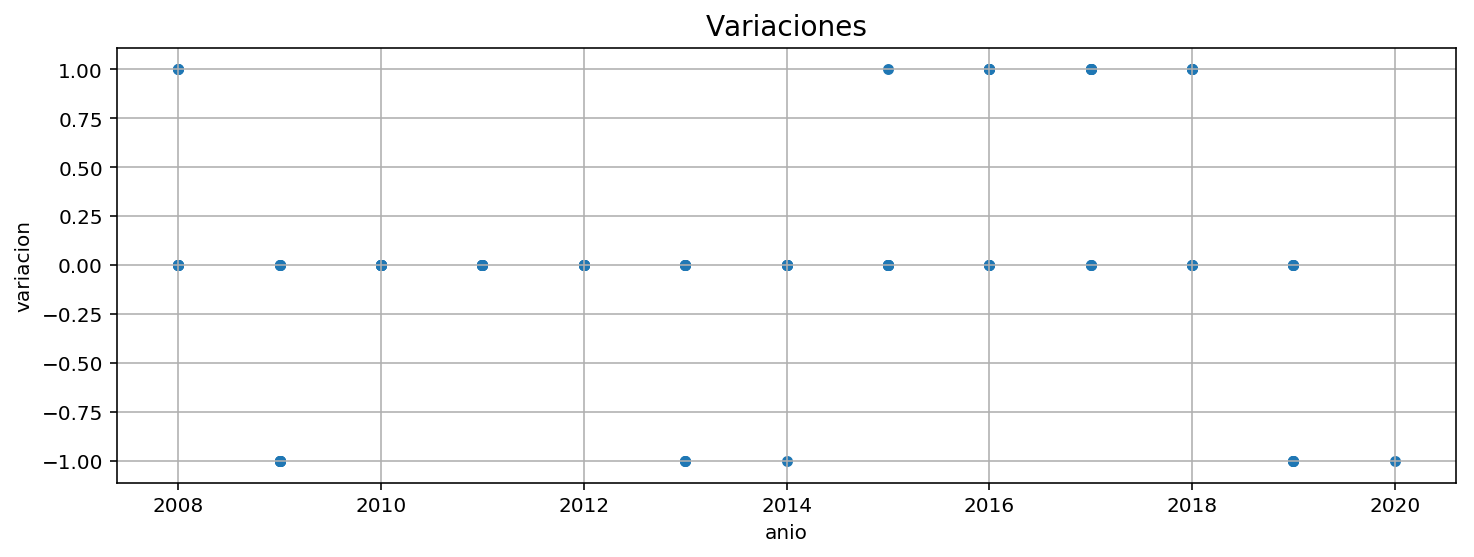

In [198]:
(df_values.plot(kind='scatter', x="anio", y="variacion"))
plt.title("Variaciones", fontsize=14)
plt.grid(alpha=1);

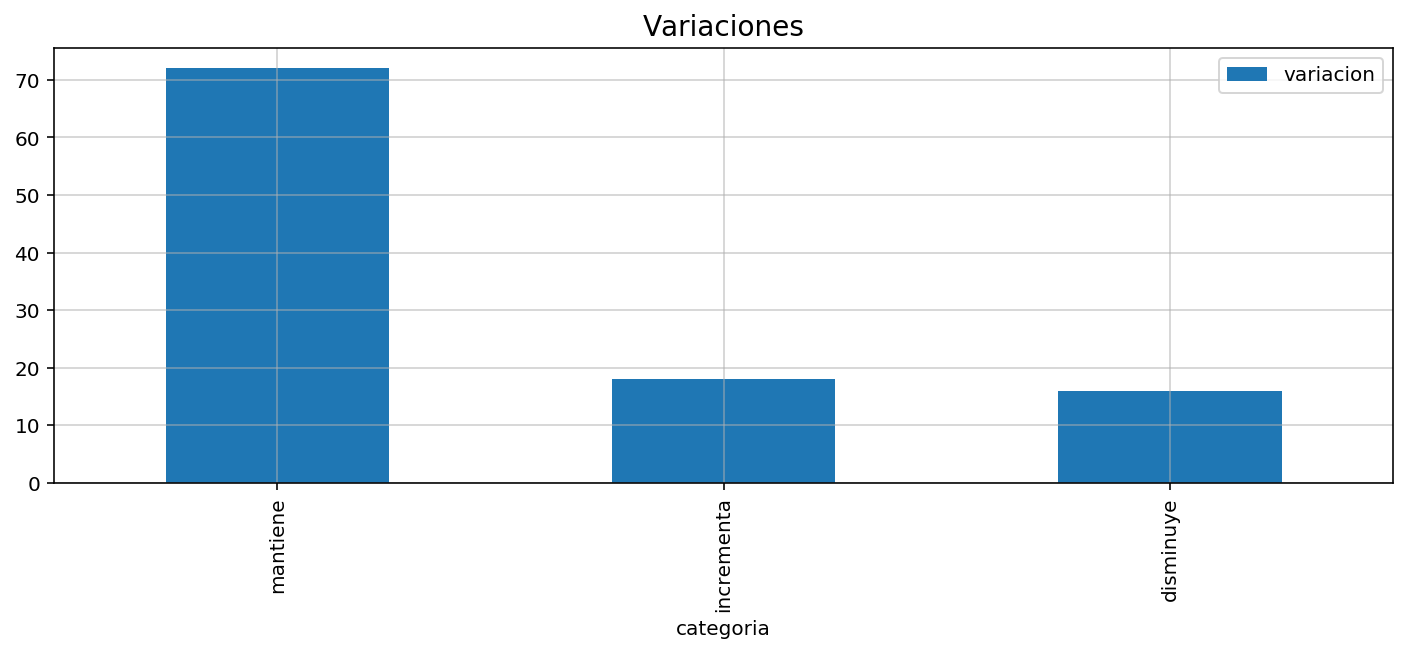

In [192]:
res.plot(kind='bar', x="categoria", y="variacion")
plt.title("Variaciones", fontsize=14)
plt.grid(alpha=0.6);

In [193]:
df_values.drop(["texto", "url"], axis=1).groupby(["anio", "categoria"]).count()

variacion
anio categoria            
2008 incrementa          3
     mantiene            7
2009 disminuye           7
     mantiene            4
2010 mantiene           11
2011 mantiene            8
2012 mantiene            8
2013 disminuye           3
     mantiene            5
2014 disminuye           1
     mantiene            7
2015 incrementa          1
     mantiene            7
2016 incrementa          5
     mantiene            4
2017 incrementa          5
     mantiene            3
2018 incrementa          4
     mantiene            4
2019 disminuye           4
     mantiene            4
2020 disminuye           1

In [194]:
res = df_values.reset_index().drop(["texto", "url"], axis=1).groupby(["fecha", "anio", "categoria"]).count().reset_index()
res

,fecha,anio,categoria,variacion
0,2008-02-15,2008,mantiene,1
1,2008-03-14,2008,mantiene,1
2,2008-04-18,2008,mantiene,1
3,2008-05-16,2008,mantiene,1
4,2008-06-20,2008,incrementa,1
...,...,...,...,...
101,2019-08-15,2019,disminuye,1
102,2019-09-26,2019,disminuye,1
103,2019-11-14,2019,disminuye,1
104,2019-12-19,2019,disminuye,1


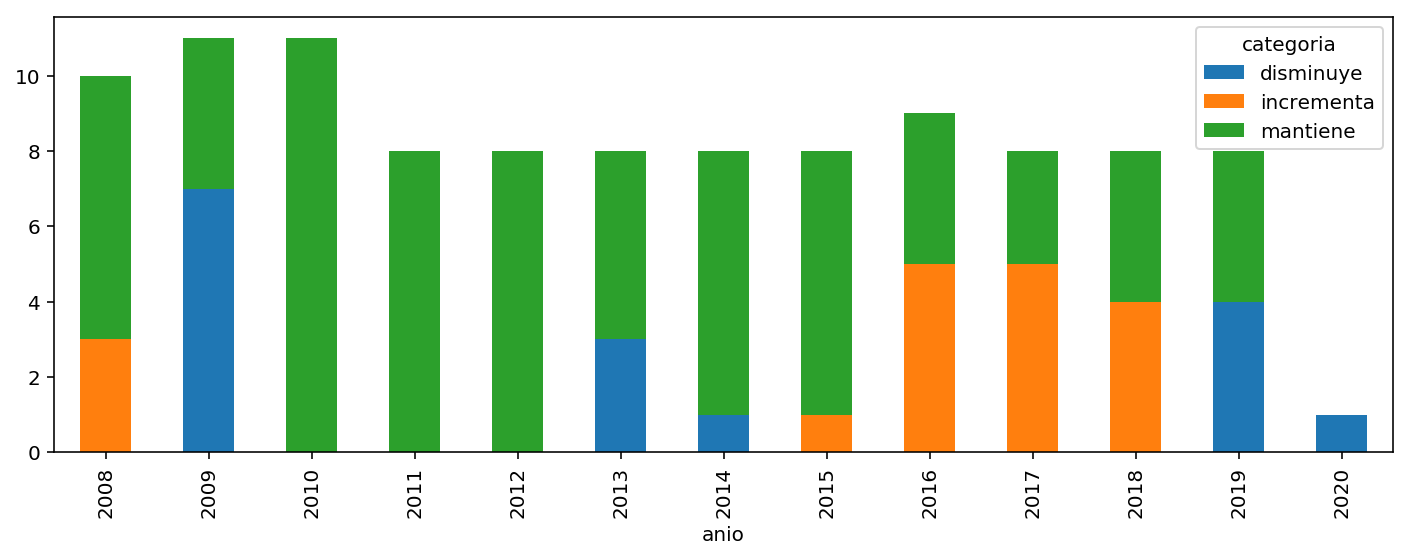

In [195]:
res.groupby(['anio','categoria']).size().unstack().plot(kind='bar',stacked=True)
plt.show()